# Initialization

In [3]:
import os
import random

import numpy as np
import torch

SEED = 3000
import sklearn
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

In [4]:
import pandas as pd
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

# Data processing

In [5]:
df = pd.read_csv('train.csv')

In [6]:
zero = df.index[df['label'] == 0].tolist()

In [7]:
df_zero = df.loc[zero]
df_zero = df_zero[:4000]

In [8]:
one = df.index[df['label'] == 1].tolist()

In [9]:
df_one = df.loc[one]
df_one = df_one[:4000]

In [10]:
df_final= pd.concat([df_one, df_zero])

In [11]:
y = df_final['label']
X = df_final.drop(columns = 'label')
X = X.reset_index(drop = True)

In [12]:
X = X/255.0

In [13]:
X.to_numpy().max()

1.0

In [14]:
np.sqrt(np.square(X).sum(axis=1)).max()

17.179045827184005

In [ ]:
# Normalizing

div_value = np.sqrt(np.square(X).sum(axis=1)).max()

X = X/div_value
c = np.sqrt(np.square(X).sum(axis=1)).max()

In [ ]:
c

In [15]:
# Norm clipping
c = 1.0

l2_values = np.sqrt(np.square(X).sum(axis=1)).to_numpy()
func = np.vectorize(lambda t: max(1, t/c))
l2 = func(l2_values)
L2 = pd.DataFrame({'L2': l2[:]})
X = X.assign(**{col: X[col] / L2['L2'] for col in list(X.columns)})

c = np.sqrt(np.square(X).sum(axis=1)).max()

In [16]:
c

1.000000000000003

In [17]:
# Adding bias here for not to deal with it later

X['bias'] = 1
cols = X.columns.tolist()
cols = cols[-1:] + cols[:-1]
X = X[cols]

C:\Users\Niaz Mohaiman Abtahi\AppData\Local\Temp\ipykernel_27196\2346172698.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X['bias'] = 1


In [18]:
# Numpy conversion

X = X.to_numpy()

In [19]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = SEED, shuffle=True)

In [20]:
y_train = np.where(y_train == 0, -1, 1)
y_test = np.where(y_test == 0, -1, 1)

# SVM model

In [21]:
class SVM:

    def __init__(self, C = 1.0):
        # C = error term
        self.C = C
        self.w = 0
        #self.b = 0

    # Huber Loss Function / Calculation
    def huberloss(self, w, h, x, y):
        # Regularizer term
        reg = 0.5 * (w * w)

        for i in range(x.shape[0]):
            # Optimization term
            opt_term = y[i] * ((np.dot(w, x[i])))
            # calculating loss        
            if abs(1-opt_term) <= h:
                loss = reg + self.C * (1+h-opt_term)**2 / (4*h)
            else:
                loss = reg + self.C * max(0, 1-opt_term)
        return loss[0][0]
    
    # Noise Generation
    def noise(self, sigmaxsensitivity, N):
        x = np.random.normal(loc = 0, scale = sigmaxsensitivity, size = (N, ))
        #r = r/np.linalg.norm(r)
        #rand_norm = np.random.gamma(N, 1/beta, 1)
        #x = rand_norm * r
        return x

    def fit(self, ep, Sensitivity, delta, X, Y, batch_size=64, learning_rate=0.001, epochs=100):
        # The number of features in X
        number_of_features = X.shape[1]

        # The number of Samples in X
        number_of_samples = X.shape[0]

        c = self.C
        # beta calculation
        # beta = ep / Sensitivity
        #q = batch_size / number_of_samples
        #T = epochs / q
        h = 0.5
        
        # Sigma calculation
        sigma = np.sqrt(2 * np.log(1.25 / delta)) / ep
        
        # Creating ids from 0 to number_of_samples - 1
        ids = np.arange(number_of_samples)

        # Shuffling the samples randomly
        np.random.shuffle(ids)

        # creating an array of zeros
        w = np.ones((1, number_of_features))
        #b = 0
        losses = []

        # Gradient Descent logic
        for i in range(epochs):
            # Calculating the Hinge Loss
            l = self.huberloss(w, h, X, Y)

            # Appending all losses 
            losses.append(l)
            
            # Starting from 0 to the number of samples with batch_size as interval
            for batch_initial in range(0, number_of_samples, batch_size):
                gradw = 0
                #gradb = 0

                for j in range(batch_initial, batch_initial+ batch_size):
                    if j < number_of_samples:
                        x = ids[j]
                        ti = Y[x] * (np.dot(w, X[x].T))

                        if ti > 1+h:
                            gradw += 0
                            #gradb += 0
                            #gradb += self.noise(sigma * Sensitivity, 1)
                            
                        elif ti < 1-h:
                            #w.r.t w 
                            gradw += c * Y[x] * X[x]
                            # w.r.t b
                            #gradb += c * Y[x]
                            #gradw += self.noise(sigma * Sensitivity, number_of_features)
                            #gradb += self.noise(sigma * Sensitivity, 1)
                            
                        else:
                            #w.r.t w 
                            gradw += c * Y[x] * X[x] * (1+h-ti) / (2*h)
                            # w.r.t b
                            #gradb += c * Y[x] * (1+h-ti) / (2*h)
                            #gradw += self.noise(sigma * Sensitivity, number_of_features)
                            #gradb += self.noise(sigma * Sensitivity, 1)
                            
                # gradient perturbation
                gradw += self.noise(sigma * Sensitivity, number_of_features)
                
                # Updating weights and bias
                w = w - 2 * learning_rate * w + learning_rate * gradw
                #b = b + 2 * learning_rate * gradb
        
        self.w = w
        #self.b = b

        return self.w, losses

    def predict(self, X):
        
        prediction = np.dot(X, self.w[0]) # w.x
        return np.sign(prediction)

In [22]:
# Sensitivity calculation
m = X_train.shape[0]

Sensitivity = 2*c/m

# Train

In [23]:
delta = 1e-5
svm = SVM()
accuracies = []
epsilon = [0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001]

for i in range(10):
    accuracy = []
    for ep in epsilon:
        w, losses = svm.fit(ep, Sensitivity, delta, X_train, y_train)
        prediction = svm.predict(X_test)
        acc = accuracy_score(prediction, y_test)
        accuracy.append(acc)
    accuracies.append(accuracy)

In [25]:
final_accuracy = np.mean(np.array(accuracies), axis = 0)

In [27]:
final_accuracy

array([0.721375 , 0.8225625, 0.994    , 0.9948125, 0.99625  , 0.99625  ])

# Overal Epsilon calculation

In [28]:
def calculate_overall_epsilon(num_epochs, sigma, C, target_delta=1e-5):
    '''
    num_epochs = number of iterations needed for convergence
    sigma = standard deviation of noise added at each iteration
    C = sensitivity of the function to which noise was added
    target_delta = target probability of failure
    '''
    if num_epochs == 0: num_epochs = 1
    if sigma is None:
        return 0, None, None
    else:
        alpha_opt = 1 + ((2/num_epochs) * np.log(1/target_delta) * (sigma/C) ** 2) ** 0.5
        epsilon = (alpha_opt * num_epochs)/(2 * (sigma/C) ** 2) + np.log(1/target_delta)/(alpha_opt-1)
        return epsilon, target_delta, alpha_opt

In [29]:
delta = 1e-5
epsilon_count = []
for ep in epsilon:
    sigma_std_dev = (np.sqrt(2 * np.log(1.25 / delta)) / ep) * Sensitivity
    a, b, c = calculate_overall_epsilon(100, sigma_std_dev, Sensitivity, delta)
    epsilon_count.append(a)

# Data visualisation

In [30]:
epsilon_count

[4.952243498197596e-05,
 9.904497647320969e-05,
 0.000495229142736359,
 0.0009904689363984943,
 0.004952770719023532,
 0.009906606530624711]

In [40]:
final_accuracy

array([0.721375 , 0.8225625, 0.994    , 0.9948125, 0.99625  , 0.99625  ])

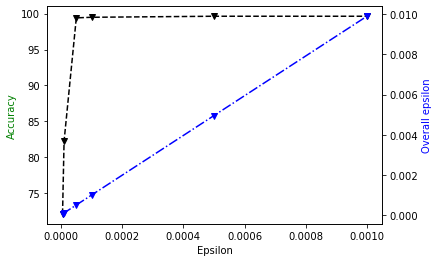

In [49]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(epsilon, np.multiply(final_accuracy, 100), 'g-', label="Accuracy", marker = 'v', color = 'k', linestyle = '--')
ax2.plot(epsilon, epsilon_count, marker = 'v', color = 'b', linestyle = '-.')

ax1.set_xlabel('Epsilon')
ax1.set_ylabel('Accuracy', color='g')
ax2.set_ylabel('Overall epsilon', color='b')

plt.show()